In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_score


In [ ]:
#loading the data
print('Loading data')
df = pd.read_csv('/content/drive/MyDrive/retail_clustering /OnlineRetail2.csv',parse_dates=['InvoiceDate'])
print('Loading completed')

Loading data
Loading completed


In [ ]:
print('--- Dimensions of data --- ')
print()
print('Number of Records: ', df.shape[0])
print('Number of Features: ', df.shape[1])
print()

--- Dimensions of data --- 

Number of Records:  541909
Number of Features:  8



In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
# data consistency checks and cleaning

# number of transations with  no unit price
no_price = df[df['UnitPrice'] <= 0].shape[0]
print('number of transactions with no unit price',no_price)
df = df[df['UnitPrice'] > 0]

# number of transations with 0 or negative quantity 
no_price = df[df['Quantity'] <= 0].shape[0]
print('number of transactions with a 0 or negative quantity',no_price)
df = df[df['Quantity'] > 0]





number of transactions with no unit price 2517
number of transactions with a 0 or negative quantity 9288


In [ ]:
# creating sales amount column 

df['Sales Amount'] = df['Quantity'] * df['UnitPrice']



In [ ]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-09-12 12:50:00,0.85,12680.0,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-09-12 12:50:00,2.10,12680.0,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-09-12 12:50:00,4.15,12680.0,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-09-12 12:50:00,4.15,12680.0,France,16.60


In [ ]:
# Creating RFM Table

end_date = max(df['InvoiceDate'])+ dt.timedelta(days=1)

rfm_df = df.groupby('CustomerID').agg({'InvoiceDate': lambda x: (end_date-max(x)).days,
                                       'InvoiceNo':'count',
                                       'Sales Amount':'sum'})

rfm_df.columns = ['Recency','Frequency','Monetary']




In [ ]:
rfm_df.head()                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,327,1,77183.60
12347.0,41,182,4310.00
12348.0,77,31,1797.24
12349.0,20,73,1757.55
12350.0,312,17,334.40


In [ ]:
rfm_df.describe()

,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000
mean,106.470954,91.720609,2054.266460
std,115.082161,228.785094,8989.230441
min,1.000000,1.000000,3.750000
25%,23.000000,17.000000,307.415000
50%,62.000000,41.000000,674.485000
75%,162.750000,100.000000,1661.740000
max,698.000000,7847.000000,280206.020000


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

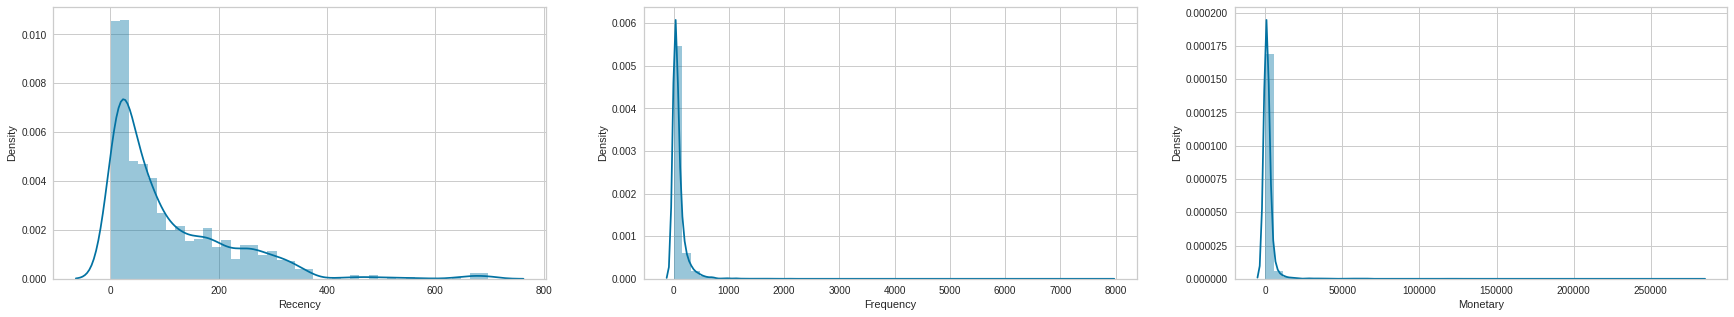

In [ ]:
fig, axes = plt.subplots(1,3,figsize=(30,5))

for i,feature in enumerate(list(rfm_df.columns)):
  sns.distplot(rfm_df[feature],ax=axes[i])

In [ ]:
# removing outliers using the 1.5 IQR method.

def remove_outliers(df,field):
  q1 = df[field].quantile(0.25)
  q3 = df[field].quantile(0.75)
  iqr = q3-q1
  lower_tail = q1 - iqr*1.5
  upper_tail = q3 + iqr*1.5

  df = df[(df[field]>=lower_tail)&(df[field]<=upper_tail)]
  
  return df

rfm_df_new = remove_outliers(rfm_df,'Recency')
rfm_df_new = remove_outliers(rfm_df,'Frequency')
rfm_df_new = remove_outliers(rfm_df,'Monetary')

In [ ]:
# descriptive statistics regarding our current rfm dataframe
display(rfm_df_new.describe())

,Recency,Frequency,Monetary
count,3911.000000,3911.000000,3911.000000
mean,114.327793,61.517003,886.654537
std,117.216400,77.311881,828.537759
min,1.000000,1.000000,3.750000
25%,26.000000,15.000000,283.510000
50%,73.000000,35.000000,588.220000
75%,175.000000,79.000000,1246.210000
max,698.000000,970.000000,3692.280000


The features 'Frequecy' and 'Monetary' have the highest correlation, with a coefficent value of 0.6 approximately.

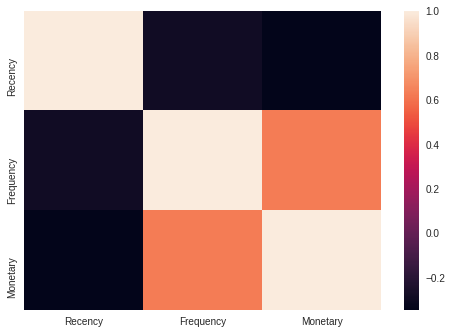

In [ ]:
# correlation heat map between variables #
sns.heatmap(rfm_df_new.corr())

All the features have different ranges, K-means is a distance based algorithm, normalising the ranges will help reduce the bias.

In [ ]:
scaler = MinMaxScaler()
rfm_normalised = pd.DataFrame(scaler.fit_transform(rfm_df_new))
rfm_normalised.columns = ['n_Recency','n_Frequency','n_Monetary']
rfm_normalised.describe()

,n_Recency,n_Frequency,n_Monetary
count,3911.000000,3911.000000,3911.000000
mean,0.162594,0.062453,0.239365
std,0.168173,0.079785,0.224625
min,0.000000,0.000000,0.000000
25%,0.035868,0.014448,0.075846
50%,0.103300,0.035088,0.158456
75%,0.249641,0.080495,0.336844
max,1.000000,1.000000,1.000000


segmenting with K-means, now we have to find the optimal amount of clusters to use.

After viewing the inertia cluster plot and the average silhouette, I have the chosen the K=5 to be the most optimal value. 

For n_clusters=2, the silhoeutte score is 0.5042501132412703
For n_clusters=3, the silhoeutte score is 0.4529213525250815
For n_clusters=4, the silhoeutte score is 0.42171302224600826
For n_clusters=5, the silhoeutte score is 0.43619938659293367
For n_clusters=6, the silhoeutte score is 0.39311340127944405
For n_clusters=7, the silhoeutte score is 0.3691418660359402
For n_clusters=8, the silhoeutte score is 0.3725745540111849
For n_clusters=9, the silhoeutte score is 0.3826552231747054
For n_clusters=10, the silhoeutte score is 0.36655944194168205


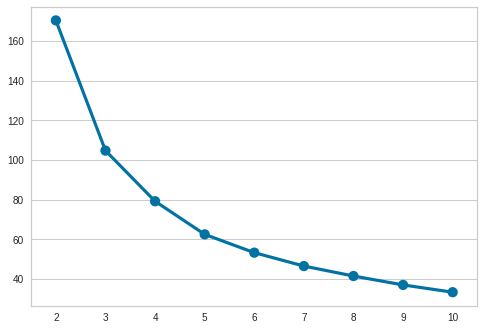

In [ ]:
SSE = []

for k in range(1,10):
  kmeans = KMeans(n_clusters=k+1, random_state=1231).fit(rfm_normalised)
  SSE.append(kmeans.inertia_)

  cluster_labels = kmeans.labels_
  

  silhouette_avg = silhouette_score(rfm_normalised,cluster_labels)

  print('For n_clusters={0}, the silhoeutte score is {1}'.format(k+1,silhouette_avg))

sns.pointplot(x=list(range(2,11)),y=SSE)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fd14b8b9cd0>,
                     model=None)

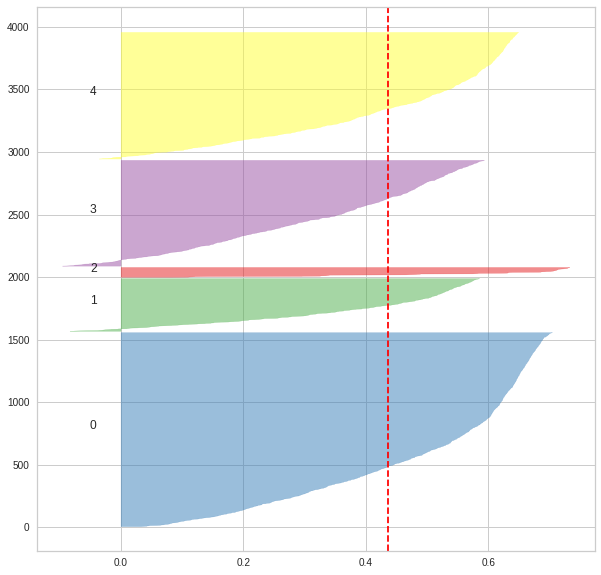

In [ ]:

fig, axes = plt.subplots(figsize=(10,10))
visual = SilhouetteVisualizer(KMeans(5,random_state=42),ax=axes,colors='yellowbrick')
visual.fit(rfm_normalised)

[0.12025613 0.74814573 0.0747247  0.10021344 0.38746771]


Text(0.5, 0, 'Monetary')

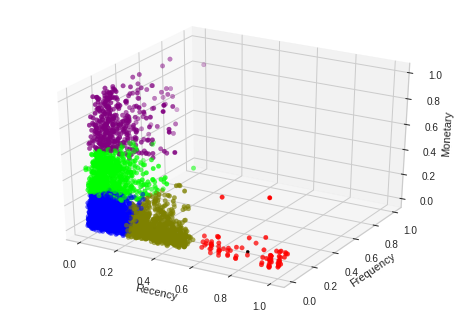

In [ ]:
model = KMeans(n_clusters=5,random_state=1231).fit(rfm_normalised)
centers = model.cluster_centers_
print(centers[:,2])
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.scatter(rfm_normalised['n_Recency'],rfm_normalised['n_Frequency'],rfm_normalised['n_Monetary'],cmap='brg',c=model.predict(rfm_normalised))
ax.scatter(centers[:,0], centers[:,1],centers[:,2],s=10,c='black')
ax.set_xlabel("Recency")

ax.set_ylabel("Frequency")

ax.set_zlabel("Monetary")

After segementing the data, customers in cluster 1, have shown to be high value customers due to the high frequency, high monetary, and low recency values they have shown.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


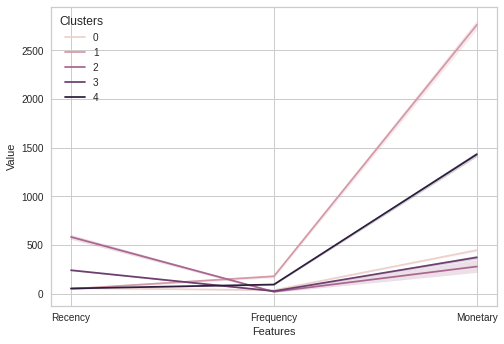

In [ ]:
rfm_ = pd.DataFrame(scaler.inverse_transform(rfm_normalised))
rfm_.columns = rfm_df_new.columns
rfm_['CustomerID'] = rfm_df_new.index
rfm_['Cluster'] =  model.labels_

melted_rfm_ = pd.melt(rfm_.reset_index(),
                                id_vars=['CustomerID','Cluster'],
                                value_vars=['Recency','Frequency','Monetary'],
                                var_name='Features',
                                value_name='Value')


sns.lineplot('Features','Value',hue='Cluster',data= melted_rfm_)
plt.legend(title='Clusters')


In [ ]:
rfm_.groupby('Cluster').agg({'Recency':['mean','min','max'],
                             'Frequency':['mean','min','max'],
                             'Monetary':['mean','min','max','count']})

Recency                ... Monetary               
               mean    min    max  ...      min      max count
Cluster                            ...                        
0         57.904057    1.0  154.0  ...     6.90   974.54  1553
1         49.523697    1.0  321.0  ...  1908.25  3692.28   422
2        582.886076  425.0  698.0  ...    15.00  2002.40    79
3        241.410661  145.0  364.0  ...     3.75  1693.88  1013
4         54.164692    1.0  299.0  ...   867.11  2207.40   844

[5 rows x 10 columns]